In [181]:
import os
import sys
import pandas as pd
from sklearn import datasets
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML
from sklearn.datasets import load_iris
from pystout import pystout
import matplotlib.pyplot as plt
import numpy as np

In [182]:
# Global Settings
pd.set_option("display.float_format", lambda x: "%.4f" % x)


# weighting

# Add weighting logic here

In [183]:
output_path = "/Users/kylenabors/Library/Screenshots/Regressions"

reg_count = 1

In [184]:
cwd = os.getcwd()
# Find and import config file
config_path = os.getcwd()

sys.path.append(config_path)
import config

database = config.database
central_banks = config.central_banks
training_data = os.path.join(database, "Training Data")
fed_docs = config.fed_docs
ecb_docs = config.ecb_docs
boe_docs = config.boe_docs

In [185]:
test = pd.read_csv(
    "/Users/kylenabors/Documents/Database/Models/FinBERT Models/taylor.csv"
)

In [186]:
sentiment = pd.date_range(start="1/1/1990", end="12/31/2024", freq="D")
sentiment = pd.DataFrame(sentiment, columns=["date"])

In [187]:
# Import inflation probability data that is stored as a dta file
inflation_prob_us = pd.read_stata(
    "/Users/kylenabors/Documents/Database/Other Data/Inflation Probabilities/USwestimates.dta"
)

inflation_prob_us = inflation_prob_us.rename(columns={"date_ym": "date"})

inflation_prob_eu = pd.read_stata(
    "/Users/kylenabors/Documents/Database/Other Data/Inflation Probabilities/EZwestimates.dta"
)

inflation_prob_eu = inflation_prob_eu.rename(columns={"date_ym": "date"})

inflation_prob = inflation_prob_us.merge(
    inflation_prob_eu, on="date", how="left", suffixes=("_us", "_eu")
)

sentiment = sentiment.merge(inflation_prob, on="date", how="left")

# sentiment = sentiment.ffill()

In [188]:
inflation_diff = pd.read_excel(
    "/Users/kylenabors/Documents/Database/Market Data/Inflation/12m cumulative inflation.xlsx"
)

print(inflation_diff.dtypes)

sentiment = pd.merge(sentiment, inflation_diff, on="date", how="left")

date               datetime64[ns]
12m_inf                   float64
target_distance           float64
high_inf                  float64
low_inf                   float64
dtype: object


In [189]:
indexes = pd.read_excel(
    "/Users/kylenabors/Documents/Database/Other Data/Indexes/five_indexes.xlsx"
)
indexes["date"] = pd.to_datetime(indexes["date"])
sentiment = pd.merge(sentiment, indexes, how="left", left_on="date", right_on="date")

In [190]:
market = pd.read_csv(f"{database}/Market Data/All Market Data.csv")
market = market.rename(columns={"PCE": "pce", "GDP": "gdp", "GDPPOT": "gdp_pot"})
market["date"] = pd.to_datetime(market["date"])

sentiment = pd.merge(sentiment, market, how="left", left_on="date", right_on="date")

In [191]:
taylor = pd.read_csv(
    f"/Users/kylenabors/Documents/Database/Market Data/Taylor/Taylor.csv"
)
taylor["date"] = pd.to_datetime(taylor["date"])
taylor = taylor.rename(columns={"Taylor": "taylor"})

sentiment = pd.merge(sentiment, taylor, how="left", left_on="date", right_on="date")

In [192]:
# # HP Filter


url_map = pd.read_csv(os.path.join(cwd, "url_map.csv"))

for i in range(len(url_map)):
    temp_dates = pd.date_range(start="1/1/1990", end="12/31/2024", freq="D")
    temp_dates = pd.DataFrame(temp_dates, columns=["date"])
    sent = pd.read_csv(url_map["finbert_url"][i])

    # Adding Weights

    # By word count

    # sent = sent[["date", "sentiment", "weight"]]
    # sent["sentiment"] = sent["sentiment"] * sent["weight"]
    # sent = sent.drop(columns=["weight"])

    # By Length

    # sent = sent[["date", "sentiment", "len"]]
    # sent["sentiment"] = sent["sentiment"] * sent["len"]
    # sent = sent.drop(columns=["len"])

    sent = sent[["date", "sentiment"]]

    sent["date"] = pd.to_datetime(sent["date"])
    sent = sent.groupby("date").mean().reset_index()

    sent = pd.merge(temp_dates, sent, how="left", left_on="date", right_on="date")

    # Set 'date' as the index for resampling
    sent.set_index("date", inplace=True)

    sent["sentiment"] = sent["sentiment"].ffill()

    # Resample to quarterly frequency
    sent = sent.resample("Q").mean()

    # Drop NaNs
    sent = sent.dropna(subset=["sentiment"])

    # Reset index to turn 'date' back into a column
    sent.reset_index(inplace=True)

    filter_df = sent.copy(deep=True)

    cycle, trend = sm.tsa.filters.hpfilter(filter_df["sentiment"], 1600)

    filter_df["sentiment_cycle"] = cycle
    filter_df["sentiment_trend"] = trend

    filter_df = filter_df[["date", "sentiment_cycle"]]
    sent = sent.drop(columns=["sentiment"])
    filter_df = filter_df.rename(columns={"sentiment_cycle": "sentiment"})
    sent = pd.merge(sent, filter_df, on="date", how="outer")
    sent = sent.groupby("date").mean().reset_index()

    sent = sent.rename(columns={"sentiment": url_map["document"][i]})
    sentiment = pd.merge(sentiment, sent, how="outer", left_on="date", right_on="date")

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_21557/217102763.py:38: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  sent = sent.resample("Q").mean()
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_21557/217102763.py:38: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  sent = sent.resample("Q").mean()
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_21557/217102763.py:38: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  sent = sent.resample("Q").mean()
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_21557/217102763.py:38: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  sent = sent.resample("Q").mean()
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_21557/217102763.py:38: FutureWarning: 'Q' is deprecated and will be removed i

In [193]:
fedfunds = pd.read_csv(
    "/Users/kylenabors/Documents/Database/Market Data/Fed Funds/Fed Funds.csv"
)
fedfunds["date"] = pd.to_datetime(fedfunds["date"])
sentiment = pd.merge(sentiment, fedfunds, how="left", left_on="date", right_on="date")

In [194]:
stocks = sentiment.copy(deep=True)
stocks = stocks[["date", "sp500_return", "stoxx"]]
stocks["log_returns"] = np.log(1 + stocks["sp500_return"])
stocks["log_returns_eu"] = np.log(1 + stocks["stoxx"])
stocks = stocks.resample("Q", on="date").sum().reset_index()

for i in range(0, 6):
    stocks[f"log_returns_{i}"] = stocks["log_returns"].shift(i)
    stocks[f"log_returns_eu_{i}"] = stocks["log_returns_eu"].shift(i)

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_21557/1053901969.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  stocks = stocks.resample("Q", on="date").sum().reset_index()


In [195]:
# Resample the final 'sentiment' DataFrame to quarterly frequency
sentiment = sentiment.drop(columns=["sp500_return", "stoxx"])
sentiment = sentiment.resample("Q", on="date").mean().reset_index()

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_21557/4229648175.py:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  sentiment = sentiment.resample("Q", on="date").mean().reset_index()


In [196]:
# merging FSI data
sentiment["fsi"] = (
    sentiment["credit"]
    + sentiment["equity_valuation"]
    + sentiment["safe_assets"]
    + sentiment["funding"]
    + sentiment["volatility"]
)

In [197]:
# Create lagged columns
for column in sentiment.columns:
    if column != "date":  # Skip the 'date' column
        sentiment[f"{column}_1"] = sentiment[column].shift(1)

for i in range(0, 5):
    sentiment[f"fed_minutes_forward_{i}"] = sentiment["fed_minutes"].shift(-i)
    sentiment[f"fed_minutes_lag_{i}"] = sentiment["fed_minutes"].shift(i)
    sentiment[f"press_conferences_forward_{i}"] = sentiment["press_conferences"].shift(
        -i
    )
    sentiment[f"taylor_forward_{i}"] = sentiment["taylor"].shift(-i)
    sentiment[f"taylor_euro_forward_{i}"] = sentiment["taylor_euro"].shift(-i)
    sentiment[f"credit_lag_{i}"] = sentiment["credit"].shift(i)
    sentiment[f"equity_valuation_lag_{i}"] = sentiment["equity_valuation"].shift(i)
    sentiment[f"safe_assets_lag_{i}"] = sentiment["safe_assets"].shift(i)
    sentiment[f"funding_lag_{i}"] = sentiment["funding"].shift(i)
    sentiment[f"volatility_lag_{i}"] = sentiment["volatility"].shift(i)
    sentiment[f"fsi_lag_{i}"] = sentiment["fsi"].shift(i)
    sentiment[f"press_conferences_lag_{i}"] = sentiment["press_conferences"].shift(i)

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_21557/2576236819.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sentiment[f"fed_minutes_lag_{i}"] = sentiment["fed_minutes"].shift(i)
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_21557/2576236819.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sentiment[f"press_conferences_forward_{i}"] = sentiment["press_conferences"].shift(
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_21557/2576236819.py:12: PerformanceWarning: DataFrame is highly f

In [198]:
sentiment = pd.merge(sentiment, stocks, how="left", left_on="date", right_on="date")

In [199]:
# sentiment = sentiment[
#     (sentiment["date"] >= "2000-01-01") & (sentiment["date"] <= "2023-01-30")
# ]

sentiment = sentiment[
    (sentiment["date"] >= "2000-06-01") & (sentiment["date"] <= "2022-06-30")
]

In [200]:
# Export sentiment as csv
sentiment.to_csv(f"{database}/Sentiment.csv", index=False)

In [201]:
print(sentiment.columns)

Index(['date', 'date_stata_us', 'higher4_5y5y_us', 'higher5_5y5y_us',
       'lower0_5y5y_us', 'lowerm1_5y5y_us', 'zc_higher4_5y_us',
       'zc_higher5_5y_us', 'zc_lower0_5y_us', 'zc_lowerm1_5y_us',
       ...
       'log_returns_1', 'log_returns_eu_1', 'log_returns_2',
       'log_returns_eu_2', 'log_returns_3', 'log_returns_eu_3',
       'log_returns_4', 'log_returns_eu_4', 'log_returns_5',
       'log_returns_eu_5'],
      dtype='object', length=217)


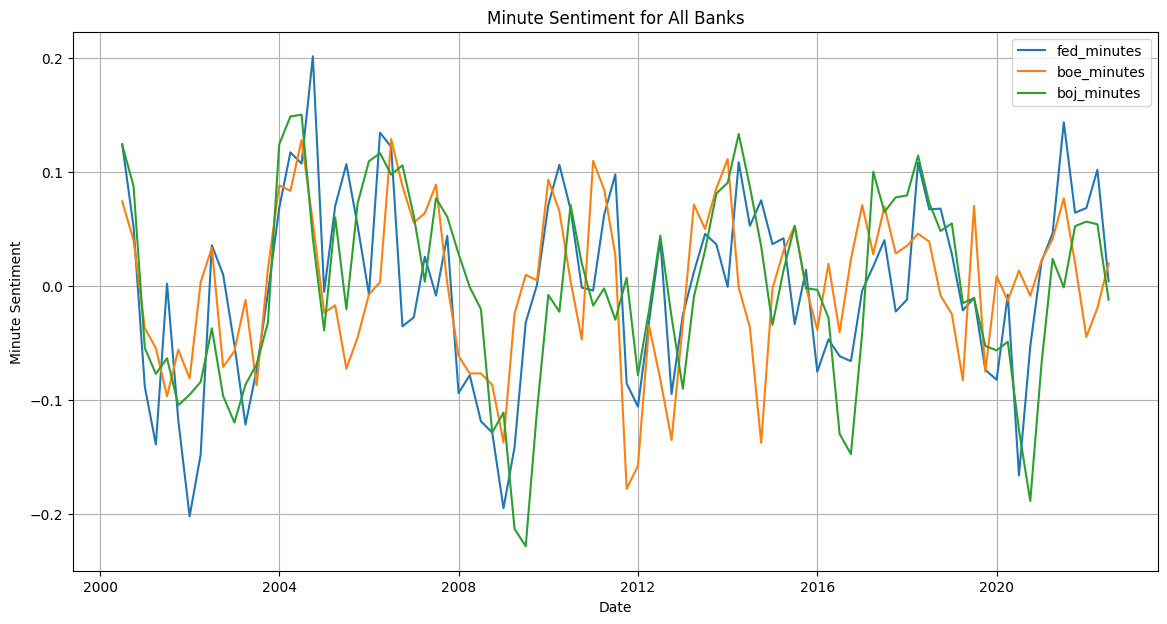

In [202]:
import matplotlib.pyplot as plt

# List of columns containing minute sentiment for all banks
minute_sentiment_columns = [
    "fed_minutes",
    "ecb_minutes",
    "boe_minutes",
    "boj_minutes",
    "boa_minutes",
    "boc_minutes",
    "boswiss_minutes",
    "bosweaden",
]

# Plotting the minute sentiment for all banks
plt.figure(figsize=(14, 7))

for column in minute_sentiment_columns:
    if column in sentiment.columns:
        plt.plot(sentiment["date"], sentiment[column], label=column)

plt.xlabel("Date")
plt.ylabel("Minute Sentiment")
plt.title("Minute Sentiment for All Banks")
plt.legend()
plt.grid(True)
plt.show()

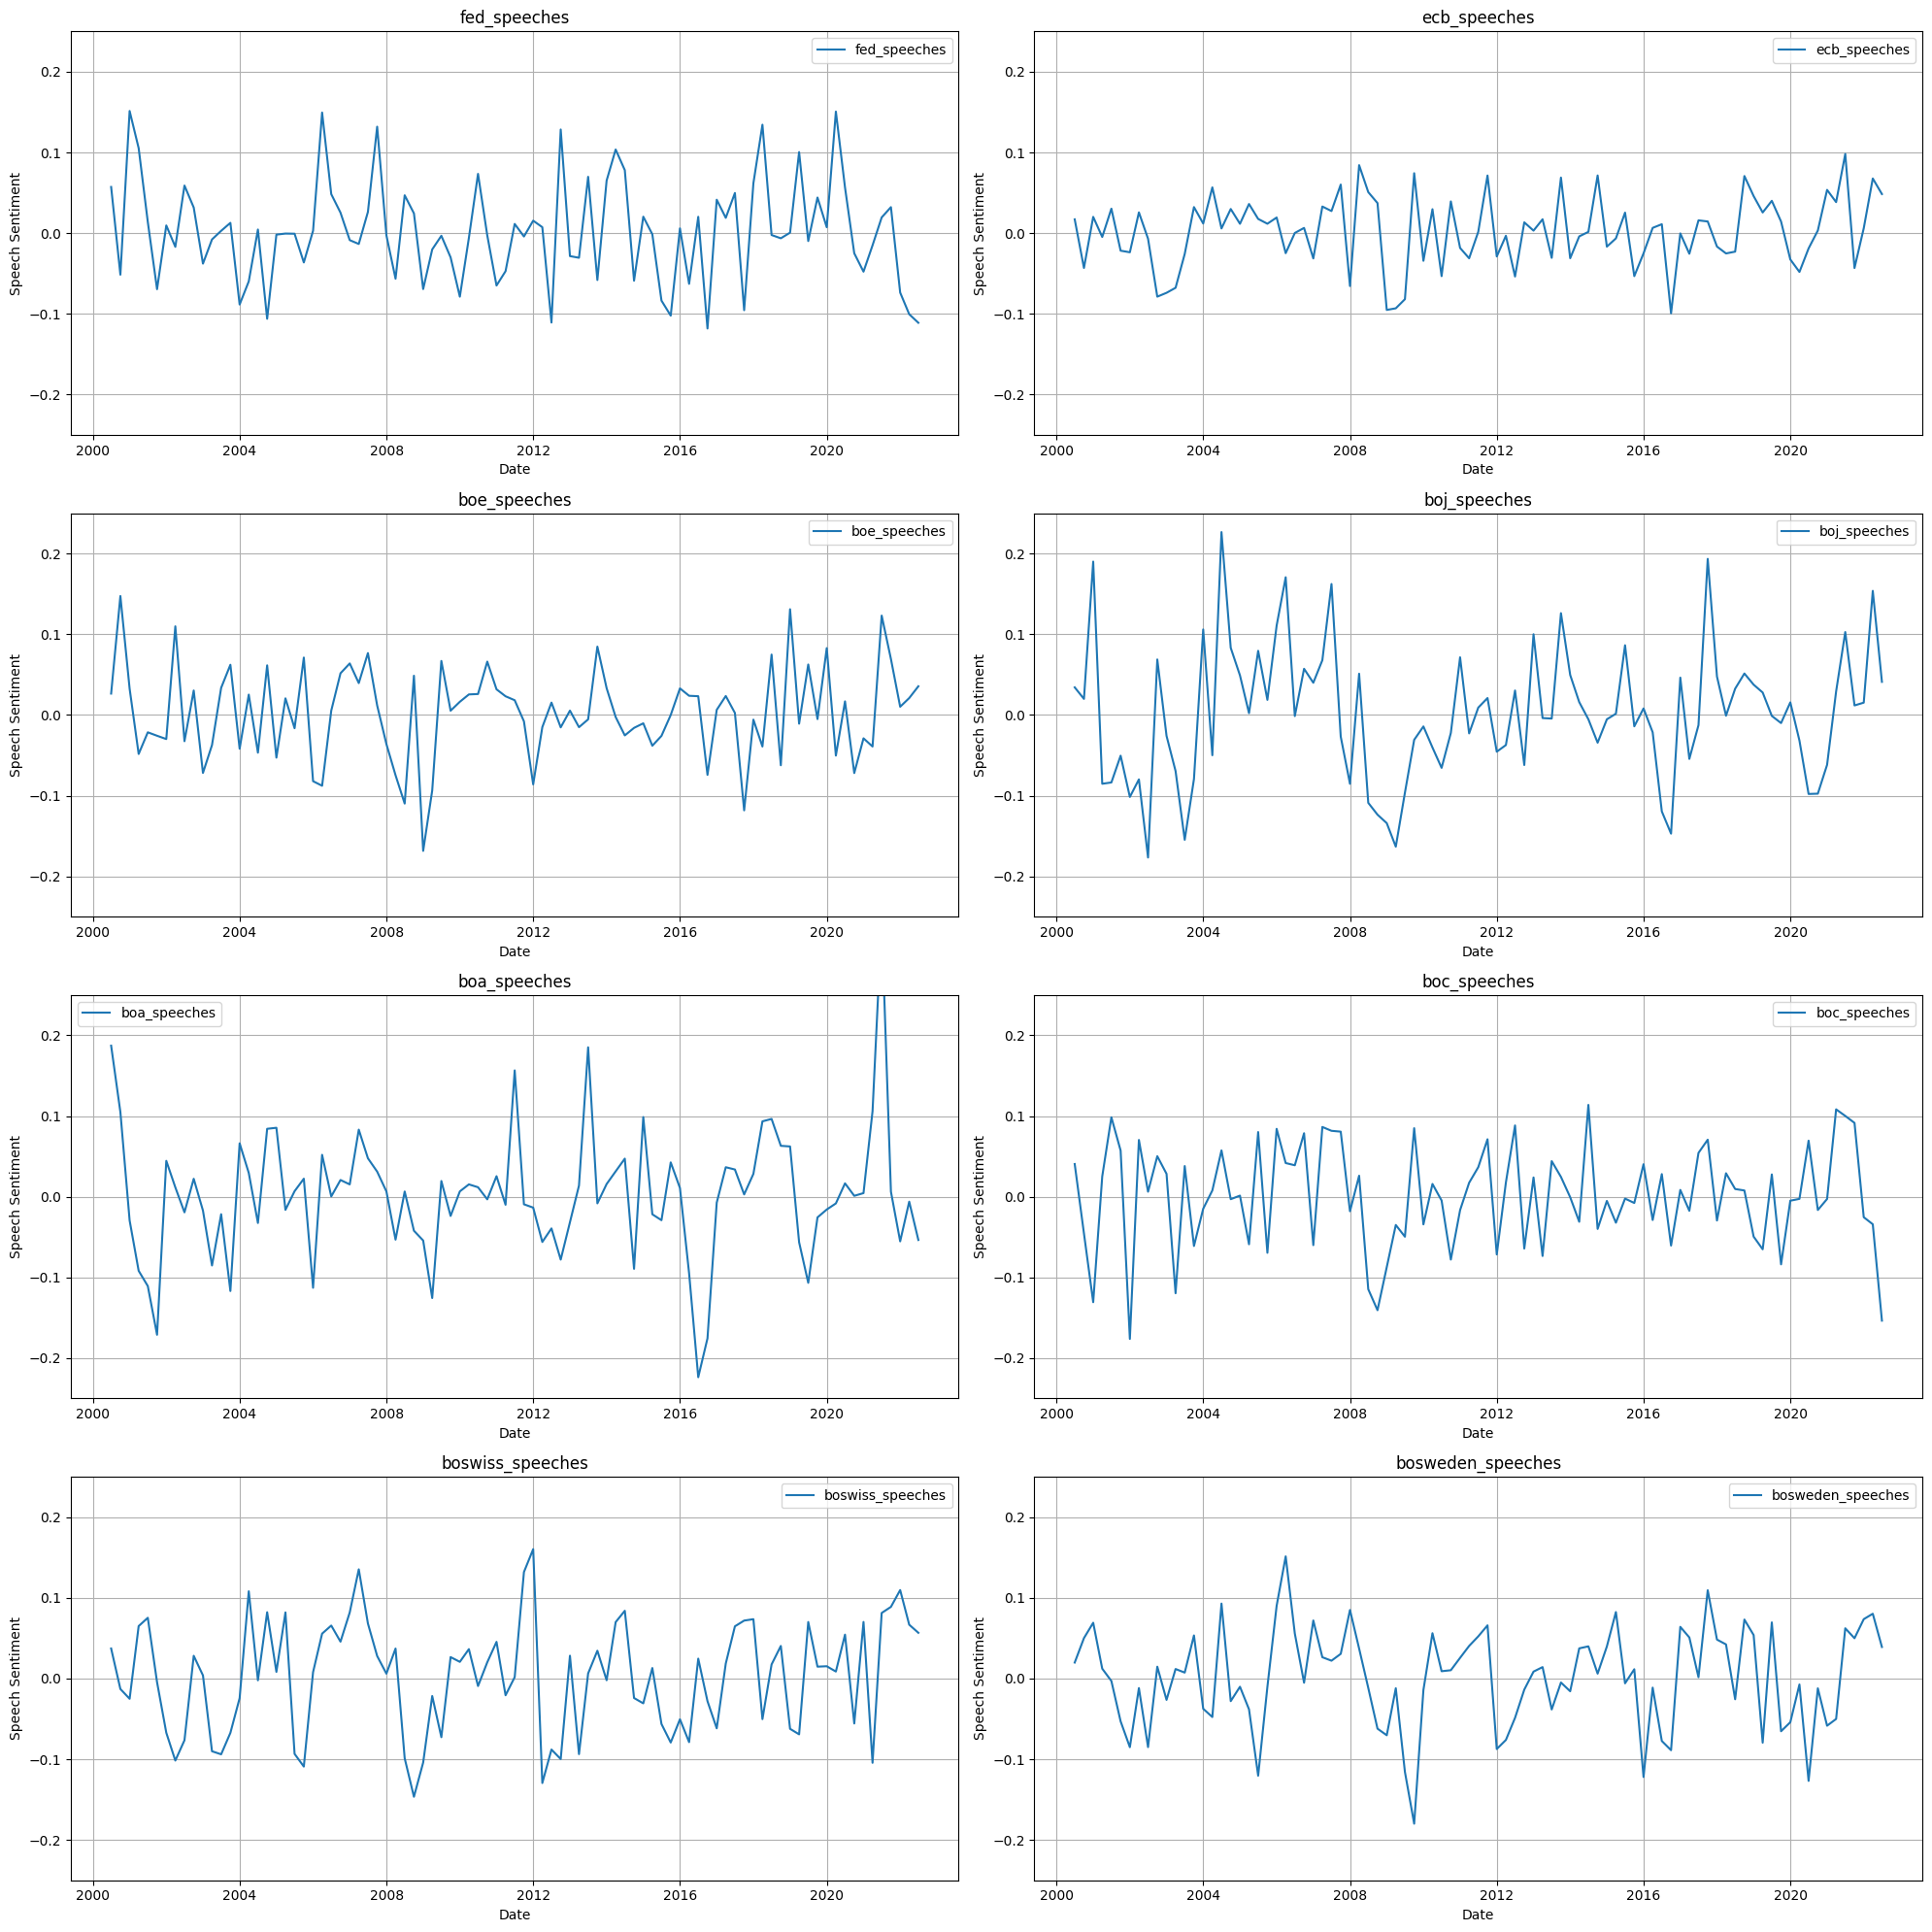

In [203]:
# List of columns containing speech sentiment for all banks
speech_sentiment_columns = [
    'fed_speeches', 
    'ecb_speeches', 
    'boe_speeches', 
    'boj_speeches', 
    'boa_speeches', 
    'boc_speeches', 
    'boswiss_speeches', 
    'bosweden_speeches',
]

# Define the layout of the subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each sentiment column in its own subplot
for i, column in enumerate(speech_sentiment_columns):
    if column in sentiment.columns:
        axes[i].plot(sentiment['date'], sentiment[column], label=column)
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Speech Sentiment')
        axes[i].set_title(column)
        axes[i].set_ylim(-0.25, 0.25)  # Set y-axis limits
        axes[i].legend()
        axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [204]:
# Table 3 Pt. 1

x = [
    "press_conferences",
    "press_conferences_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Variables")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "press_conferences",
        "press_conferences_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "press_conferences": "ECB Sent (t)",
        "press_conferences_1": "ECB Sent (t-1)",
        "fed_minutes_1": "Fed Sent (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

# Output to picture
pystout(latex_output, output=f"{output_path}/Regression {reg_count}.png", dpi=500)
reg_count += 1

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Variables}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 ECB Sent (t) & 0.253$^{***}$ & 0.272$^{***}$ & 0.095$^{}$ & 0.055$^{}$ & -0.141$^{}$ \\
& (0.090) & (0.085) & (0.084) & (0.089) & (0.090) \\
 ECB Sent (t-1) & -0.129$^{}$ & -0.281$^{***}$ & -0.312$^{***}$ & -0.428$^{***}$ & -0.251$^{***}$ \\
& (0.088) & (0.084) & (0.083) & (0.092) & (0.087) \\
 Fed Sent (t-1) & 0.535$^{***}$ & 0.303$^{***}$ & 0.275$^{***}$ & 0.271$^{***}$ & 0.069$^{}$ \\
& (0.099) & (0.097) & (0.103) & (0.097) & (0.097) \\
\hline \
 Observations & 89 & 89 & 89 & 89 & 89 \\
 $R^2$ & 0.388 & 0.170 & 0.123 & 0.218 & 0.179 \\
 Adjusted $R^2$ & 0.367 & 0.140 & 0.092 & 0.191 & 0.150 \\
 Residual Std. Error & 0.066 (df=85) 

TypeError: pystout() got an unexpected keyword argument 'output'

In [ ]:
# Table 3 Pt. 2

x = [
    "fed_minutes",
    "fed_minutes_1",
    "press_conferences_1",
]

yvar0 = "press_conferences"
yvar1 = "press_conferences_forward_1"
yvar2 = "press_conferences_forward_2"
yvar3 = "press_conferences_forward_3"
yvar4 = "press_conferences_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Variables")
stargazer.custom_columns(
    [
        "ECB Sent. (t)",
        "ECB Sent. (t+1)",
        "ECB Sent. (t+2)",
        "ECB Sent. (t+3)",
        "ECB Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "fed_minutes",
        "fed_minutes_1",
        "press_conferences_1",
    ]
)

stargazer.rename_covariates(
    {
        "fed_minutes": "Fed Sent (t)",
        "fed_minutes_1": "Fed Sent (t-1)",
        "press_conferences_1": "ECB Sent (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

# Output to picture
pystout(latex_output, output=f"{output_path}/Regression {reg_count}.png", dpi=500)
reg_count += 1

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Variables}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{ECB Sent. (t)} & \multicolumn{1}{c}{ECB Sent. (t+1)} & \multicolumn{1}{c}{ECB Sent. (t+2)} & \multicolumn{1}{c}{ECB Sent. (t+3)} & \multicolumn{1}{c}{ECB Sent. (t+4)}  \\
\hline \
 Fed Sent (t) & 0.373$^{***}$ & 0.258$^{}$ & 0.190$^{}$ & 0.291$^{**}$ & 0.131$^{}$ \\
& (0.134) & (0.159) & (0.140) & (0.148) & (0.162) \\
 Fed Sent (t-1) & -0.121$^{}$ & 0.064$^{}$ & 0.131$^{}$ & 0.007$^{}$ & 0.194$^{}$ \\
& (0.133) & (0.156) & (0.157) & (0.172) & (0.145) \\
 ECB Sent (t-1) & 0.544$^{***}$ & 0.185$^{*}$ & 0.077$^{}$ & -0.035$^{}$ & -0.194$^{*}$ \\
& (0.070) & (0.104) & (0.104) & (0.121) & (0.116) \\
\hline \
 Observations & 89 & 89 & 89 & 89 & 89 \\
 $R^2$ & 0.409 & 0.122 & 0.074 & 0.055 & 0.061 \\
 Adjusted $R^2$ & 0.388 & 0.091 & 0.041 & 0.021 & 0.027 \\
 Residual Std. Error & 0.080 (df=85) & 0.097 (df=85) & 0.099

In [ ]:
# # Define the independent variables for each regression
# x = ["fed_minutes", "fed_minutes_1", "fedfunds_1"]

# yvar0 = "fedfunds"
# yvar1 = "fedfunds_forward_1"
# yvar2 = "fedfunds_forward_2"
# yvar3 = "fedfunds_forward_3"
# yvar4 = "fedfunds_forward_4"


# # Prepare the exogenous variables for each regression
# exog0 = sm.add_constant(sentiment[x]).dropna()
# exog1 = sm.add_constant(sentiment[x]).dropna()
# exog2 = sm.add_constant(sentiment[x]).dropna()
# exog3 = sm.add_constant(sentiment[x]).dropna()
# exog4 = sm.add_constant(sentiment[x]).dropna()


# # Fit the regression models
# reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
# reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
# reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
# reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
# reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# # Create the Stargazer object
# stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# # Customize the Stargazer output
# stargazer.show_model_numbers(False)
# stargazer.significant_digits(3)

# # Display the Stargazer output
# display(HTML(stargazer.render_html()))
# print(stargazer.render_latex())

In [ ]:
# Define the independent variables for each regression
x = [
    "taylor_1",
    "fed_minutes",
    "fed_minutes_lag_1",
]

yvar0 = "taylor_forward_0"
yvar1 = "taylor_forward_1"
yvar2 = "taylor_forward_2"
yvar3 = "taylor_forward_3"
yvar4 = "taylor_forward_4"

# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()

# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")

# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.title("Taylor Rule US Regressed on FOMC Minute Sentiment")
stargazer.custom_columns(
    [
        "Taylor US(t)",
        "Taylor US(t+1)",
        "Taylor US(t+2)",
        "Taylor US(t+3)",
        "Taylor US(t+4)",
    ]
)
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.covariate_order(
    [
        "fed_minutes",
        "fed_minutes_lag_1",
        "taylor_1",
    ]
)
stargazer.rename_covariates(
    {
        "fed_minutes": "Fed(t)",
        "fed_minutes_lag_1": "Fed(t-1)",
        "taylor_1": "Taylor US(t-1)",
    }
)

# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

# Output to picture
pystout(latex_output, output=f"{output_path}/Regression {reg_count}.png", dpi=500)
reg_count += 1

\begin{table}[H] \centering
  \caption{Taylor Rule US Regressed on FOMC Minute Sentiment}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Taylor US(t)} & \multicolumn{1}{c}{Taylor US(t+1)} & \multicolumn{1}{c}{Taylor US(t+2)} & \multicolumn{1}{c}{Taylor US(t+3)} & \multicolumn{1}{c}{Taylor US(t+4)}  \\
\hline \
 Fed(t) & 5.654$^{**}$ & 6.937$^{***}$ & 10.317$^{***}$ & 12.002$^{***}$ & 11.461$^{***}$ \\
& (2.224) & (1.686) & (2.367) & (3.099) & (3.931) \\
 Fed(t-1) & -0.186$^{}$ & 2.542$^{}$ & 2.256$^{}$ & 1.336$^{}$ & 0.928$^{}$ \\
& (1.669) & (2.180) & (2.361) & (3.040) & (3.510) \\
 Taylor US(t-1) & 0.957$^{***}$ & 0.866$^{***}$ & 0.738$^{***}$ & 0.564$^{***}$ & 0.379$^{***}$ \\
& (0.057) & (0.076) & (0.094) & (0.119) & (0.123) \\
\hline \
 Observations & 89 & 89 & 89 & 89 & 89 \\
 $R^2$ & 0.862 & 0.737 & 0.599 & 0.423 & 0.260 \\
 Adjusted $R^2$ & 0.857 & 0.728 & 0.584 & 0.402 & 0.233 \\
 Residual Std. Error & 0.938 (df=85) & 1.368 (df=85) & 1.752 

In [ ]:
# Define the independent variables for each regression
x = [
    "taylor_euro_1",
    "press_conferences",
    "press_conferences_lag_1",
]

yvar0 = "taylor_euro_forward_0"
yvar1 = "taylor_euro_forward_1"
yvar2 = "taylor_euro_forward_2"
yvar3 = "taylor_euro_forward_3"
yvar4 = "taylor_euro_forward_4"

# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()

# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")

# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.title("Taylor Rule Euro Regressed on FOMC Minute Sentiment")
stargazer.custom_columns(
    [
        "Taylor Euro(t)",
        "Taylor Euro(t+1)",
        "Taylor Euro(t+2)",
        "Taylor Euro(t+3)",
        "Taylor Euro(t+4)",
    ]
)
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.covariate_order(
    [
        "press_conferences",
        "press_conferences_lag_1",
        "taylor_euro_1",
    ]
)
stargazer.rename_covariates(
    {
        "press_conferences": "Press Conf(t)",
        "press_conferences_lag_1": "Press Conf(t-1)",
        "taylor_euro_1": "Taylor Euro(t-1)",
    }
)

# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

# Output to picture
pystout(latex_output, output=f"{output_path}/Regression {reg_count}.png", dpi=500)
reg_count += 1

\begin{table}[H] \centering
  \caption{Taylor Rule Euro Regressed on FOMC Minute Sentiment}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Taylor Euro(t)} & \multicolumn{1}{c}{Taylor Euro(t+1)} & \multicolumn{1}{c}{Taylor Euro(t+2)} & \multicolumn{1}{c}{Taylor Euro(t+3)} & \multicolumn{1}{c}{Taylor Euro(t+4)}  \\
\hline \
 Press Conf(t) & 0.545$^{}$ & 2.052$^{*}$ & 3.997$^{**}$ & 4.103$^{**}$ & 4.409$^{*}$ \\
& (0.553) & (1.085) & (1.622) & (1.951) & (2.389) \\
 Press Conf(t-1) & 1.874$^{***}$ & 2.930$^{***}$ & 2.544$^{*}$ & 3.217$^{*}$ & 3.498$^{*}$ \\
& (0.578) & (1.056) & (1.375) & (1.702) & (2.074) \\
 Taylor Euro(t-1) & 1.013$^{***}$ & 1.002$^{***}$ & 0.987$^{***}$ & 0.940$^{***}$ & 0.886$^{***}$ \\
& (0.029) & (0.055) & (0.084) & (0.110) & (0.129) \\
\hline \
 Observations & 89 & 89 & 89 & 89 & 89 \\
 $R^2$ & 0.941 & 0.846 & 0.718 & 0.578 & 0.463 \\
 Adjusted $R^2$ & 0.939 & 0.841 & 0.708 & 0.564 & 0.444 \\
 Residual Std. Error & 0.456 (df=85)

In [ ]:
# Fed SR LR ECB SR LR

x0 = [
    "higher4_5y5y_us",
    "higher4_5y5y_us_1",
    "lower0_5y5y_us",
    "lower0_5y5y_us_1",
    "fed_minutes_1",
]

x1 = [
    "zc_higher4_5y_us",
    "zc_higher4_5y_us_1",
    "zc_lower0_5y_us",
    "zc_lower0_5y_us_1",
    "fed_minutes_1",
]

x2 = [
    "higher4_5y5y_eu",
    "higher4_5y5y_eu_1",
    "lower0_5y5y_eu",
    "lower0_5y5y_eu_1",
    "press_conferences_1",
]

x3 = [
    "zc_higher4_5y_eu",
    "zc_higher4_5y_eu_1",
    "zc_lower0_5y_eu",
    "zc_lower0_5y_eu_1",
    "press_conferences_1",
]


yvar = "fed_minutes"
yvar1 = "fed_minutes"
yvar2 = "press_conferences"
yvar3 = "press_conferences"

exog0 = (sm.add_constant(sentiment[x0])).dropna()
exog1 = (sm.add_constant(sentiment[x1])).dropna()
exog2 = (sm.add_constant(sentiment[x2])).dropna()
exog3 = (sm.add_constant(sentiment[x3])).dropna()

reg0 = sm.OLS(endog=sentiment[yvar].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")

stargazer = Stargazer([reg0, reg1, reg2, reg3])
stargazer.title(
    "Regressing Fed Sentiment on SP500 Returns and Regressing ECB Sentiment on STOXX 600 Returns"
)
stargazer.custom_columns(["SR Fed(t)", "LR Fed(t)", "SR ECB(t)", "LR ECB(t)"])
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.covariate_order(
    [
        "higher4_5y5y_us",
        "higher4_5y5y_us_1",
        "lower0_5y5y_us",
        "lower0_5y5y_us_1",
        "zc_higher4_5y_us",
        "zc_higher4_5y_us_1",
        "zc_lower0_5y_us",
        "zc_lower0_5y_us_1",
        "higher4_5y5y_eu",
        "higher4_5y5y_eu_1",
        "lower0_5y5y_eu",
        "lower0_5y5y_eu_1",
        "zc_higher4_5y_eu",
        "zc_higher4_5y_eu_1",
        "zc_lower0_5y_eu",
        "zc_lower0_5y_eu_1",
        "fed_minutes_1",
        "press_conferences_1",
    ]
)
stargazer.rename_covariates(
    {
        "higher4_5y5y_us": "Inflation(t)",
        "higher4_5y5y_us_1": "Inflation(t-1)",
        "lower0_5y5y_us": "Deflation(t)",
        "lower0_5y5y_us_1": "Deflation(t-1)",
        "zc_higher4_5y_us": "Inflation(t)",
        "zc_higher4_5y_us_1": "Inflation(t-1)",
        "zc_lower0_5y_us": "Deflation(t)",
        "zc_lower0_5y_us_1": "Deflation(t-1)",
        "higher4_5y5y_eu": "Inflation(t)",
        "higher4_5y5y_eu_1": "Inflation(t-1)",
        "lower0_5y5y_eu": "Deflation(t)",
        "lower0_5y5y_eu_1": "Deflation(t-1)",
        "zc_higher4_5y_eu": "Inflation(t)",
        "zc_higher4_5y_eu_1": "Inflation(t-1)",
        "zc_lower0_5y_eu": "Deflation(t)",
        "zc_lower0_5y_eu_1": "Deflation(t)",
        "fed_minutes_1": "Fed(t-1)",
        "press_conferences_1": "ECB(t-1)",
    },
)
stargazer.add_custom_notes(
    [
        "The unit for t is the time between a given meeting and the previous meeting for the given Central Bank."
    ]
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Regressing Fed Sentiment on SP500 Returns and Regressing ECB Sentiment on STOXX 600 Returns}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{SR Fed(t)} & \multicolumn{1}{c}{LR Fed(t)} & \multicolumn{1}{c}{SR ECB(t)} & \multicolumn{1}{c}{LR ECB(t)}  \\
\hline \
 Inflation(t) & 0.151$^{}$ & & & \\
& (0.609) & & & \\
 Inflation(t-1) & 0.512$^{}$ & & & \\
& (0.579) & & & \\
 Deflation(t) & -2.090$^{***}$ & & & \\
& (0.598) & & & \\
 Deflation(t-1) & 0.708$^{}$ & & & \\
& (0.571) & & & \\
 Inflation(t) & & 0.443$^{}$ & & \\
& & (0.384) & & \\
 Inflation(t-1) & & -0.465$^{}$ & & \\
& & (0.451) & & \\
 Deflation(t) & & -2.689$^{***}$ & & \\
& & (0.478) & & \\
 Deflation(t-1) & & 1.841$^{***}$ & & \\
& & (0.523) & & \\
 Inflation(t) & & & -0.689$^{}$ & \\
& & & (0.976) & \\
 Inflation(t-1) & & & -0.246$^{}$ & \\
& & & (0.973) & \\
 Deflation(t) & & & -0.922$^{*}$ & \\
& & & (0.540) & \\
 Deflation(t-1) & & & 0.119$^{}$ &

In [ ]:
# Fed SR LR ECB SR LR

x0 = [
    "higher4_5y5y_us",
    "higher4_5y5y_us_1",
    "lower0_5y5y_us",
    "lower0_5y5y_us_1",
    "fed_minutes_1",
    "log_returns_0",
    "log_returns_1",
    "log_returns_2",
    "log_returns_3",
    "log_returns_4",
    "log_returns_5",
    "12m_inf",
    "12m_inf_1",
]

x1 = [
    "zc_higher4_5y_us",
    "zc_higher4_5y_us_1",
    "zc_lower0_5y_us",
    "zc_lower0_5y_us_1",
    "fed_minutes_1",
    "log_returns_0",
    "log_returns_1",
    "log_returns_2",
    "log_returns_3",
    "log_returns_4",
    "log_returns_5",
    "12m_inf",
    "12m_inf_1",
]

x2 = [
    "higher4_5y5y_eu",
    "higher4_5y5y_eu_1",
    "lower0_5y5y_eu",
    "lower0_5y5y_eu_1",
    "press_conferences_1",
    "log_returns_eu_0",
    "log_returns_eu_1",
    "log_returns_eu_2",
    "log_returns_eu_3",
    "log_returns_eu_4",
    "log_returns_eu_5",
]

x3 = [
    "zc_higher4_5y_eu",
    "zc_higher4_5y_eu_1",
    "zc_lower0_5y_eu",
    "zc_lower0_5y_eu_1",
    "press_conferences_1",
    "log_returns_eu_0",
    "log_returns_eu_1",
    "log_returns_eu_2",
    "log_returns_eu_3",
    "log_returns_eu_4",
    "log_returns_eu_5",
]


yvar = "fed_minutes"
yvar1 = "fed_minutes"
yvar2 = "press_conferences"
yvar3 = "press_conferences"

exog0 = (sm.add_constant(sentiment[x0])).dropna()
exog1 = (sm.add_constant(sentiment[x1])).dropna()
exog2 = (sm.add_constant(sentiment[x2])).dropna()
exog3 = (sm.add_constant(sentiment[x3])).dropna()

reg0 = sm.OLS(endog=sentiment[yvar].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")

stargazer = Stargazer([reg0, reg1, reg2, reg3])
stargazer.title(
    "Regressing Fed Sentiment on SP500 Returns and Regressing ECB Sentiment on STOXX 600 Returns"
)
stargazer.custom_columns(["Fed(t)", "Fed(t)", "ECB(t)", "ECB(t)"])
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.covariate_order(
    [
        "12m_inf",
        "12m_inf_1",
        "higher4_5y5y_us",
        "higher4_5y5y_us_1",
        "lower0_5y5y_us",
        "lower0_5y5y_us_1",
        "zc_higher4_5y_us",
        "zc_higher4_5y_us_1",
        "zc_lower0_5y_us",
        "zc_lower0_5y_us_1",
        "higher4_5y5y_eu",
        "higher4_5y5y_eu_1",
        "lower0_5y5y_eu",
        "lower0_5y5y_eu_1",
        "zc_higher4_5y_eu",
        "zc_higher4_5y_eu_1",
        "zc_lower0_5y_eu",
        "zc_lower0_5y_eu_1",
        "log_returns_0",
        "log_returns_1",
        "log_returns_2",
        "log_returns_3",
        "log_returns_4",
        "log_returns_5",
        "log_returns_eu_0",
        "log_returns_eu_1",
        "log_returns_eu_2",
        "log_returns_eu_3",
        "log_returns_eu_4",
        "log_returns_eu_5",
        "fed_minutes_1",
        "press_conferences_1",
    ]
)
stargazer.rename_covariates(
    {
        "12m_inf": "Inflation(t)",
        "12m_inf_1": "Inflation(t-1)",
        "higher4_5y5y_us": "Inflation Proj. SR(t)",
        "higher4_5y5y_us_1": "Inflation Proj. SR(t-1)",
        "lower0_5y5y_us": "Deflation Proj. SR(t)",
        "lower0_5y5y_us_1": "Deflation Proj. SR(t-1)",
        "zc_higher4_5y_us": "Inflation Proj. LR(t)",
        "zc_higher4_5y_us_1": "Inflation Proj. LR(t-1)",
        "zc_lower0_5y_us": "Deflation Proj. LR(t)",
        "zc_lower0_5y_us_1": "Deflation Proj. LR(t-1)",
        "higher4_5y5y_eu": "Inflation Proj. SR(t)",
        "higher4_5y5y_eu_1": "Inflation Proj. SR(t-1)",
        "lower0_5y5y_eu": "Deflation Proj. SR(t)",
        "lower0_5y5y_eu_1": "Deflation Proj. SR(t-1)",
        "zc_higher4_5y_eu": "Inflation Proj. LR(t)",
        "zc_higher4_5y_eu_1": "Inflation Proj. LR(t-1)",
        "zc_lower0_5y_eu": "Deflation Proj. LR(t)",
        "zc_lower0_5y_eu_1": "Deflation Proj. LR(t)",
        "log_returns_0": "SP00 Returns(t)",
        "log_returns_1": "SP00 Returns(t-1)",
        "log_returns_2": "SP00 Returns(t-2)",
        "log_returns_3": "SP00 Returns(t-3)",
        "log_returns_4": "SP00 Returns(t-4)",
        "log_returns_5": "SP00 Returns(t-5)",
        "fed_minutes_1": "Fed(t-1)",
        "log_returns_eu_0": "STOXX600 Returns(t)",
        "log_returns_eu_1": "STOXX600 Returns(t-1)",
        "log_returns_eu_2": "STOXX600 Returns(t-2)",
        "log_returns_eu_3": "STOXX600 Returns(t-3)",
        "log_returns_eu_4": "STOXX600 Returns(t-4)",
        "log_returns_eu_5": "STOXX600 Returns(t-5)",
        "press_conferences_1": "ECB(t-1)",
    },
)
stargazer.add_custom_notes(
    [
        "The unit for t is the time between a given meeting and the previous meeting for the given Central Bank."
    ]
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Regressing Fed Sentiment on SP500 Returns and Regressing ECB Sentiment on STOXX 600 Returns}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed(t)} & \multicolumn{1}{c}{Fed(t)} & \multicolumn{1}{c}{ECB(t)} & \multicolumn{1}{c}{ECB(t)}  \\
\hline \
 Inflation(t) & 0.021$^{*}$ & -0.001$^{}$ & & \\
& (0.011) & (0.011) & & \\
 Inflation(t-1) & -0.025$^{*}$ & -0.010$^{}$ & & \\
& (0.014) & (0.011) & & \\
 Inflation Proj. SR(t) & 0.671$^{}$ & & & \\
& (0.595) & & & \\
 Inflation Proj. SR(t-1) & -0.190$^{}$ & & & \\
& (0.538) & & & \\
 Deflation Proj. SR(t) & -0.445$^{}$ & & & \\
& (0.693) & & & \\
 Deflation Proj. SR(t-1) & -0.314$^{}$ & & & \\
& (0.653) & & & \\
 Inflation Proj. LR(t) & & 0.640$^{}$ & & \\
& & (0.419) & & \\
 Inflation Proj. LR(t-1) & & -0.531$^{}$ & & \\
& & (0.354) & & \\
 Deflation Proj. LR(t) & & -1.702$^{***}$ & & \\
& & (0.641) & & \\
 Deflation Proj. LR(t-1) & & 1.234$^{*}$ & & \\
& & (0.722) 

In [ ]:
# Define the independent variables for each regression
x = [
    "fsi",
    "fsi_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Sentiment Index")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "fsi",
        "fsi_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "fsi": "Financial Sentiment Index",
        "fsi_1": "Financial Sentiment Index (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Financial Sentiment Index & -0.013$^{***}$ & -0.011$^{***}$ & -0.009$^{**}$ & -0.008$^{**}$ & -0.002$^{}$ \\
& (0.002) & (0.002) & (0.004) & (0.004) & (0.004) \\
 Financial Sentiment Index (t-1) & 0.007$^{***}$ & 0.005$^{}$ & 0.007$^{*}$ & 0.011$^{***}$ & 0.004$^{}$ \\
& (0.002) & (0.003) & (0.004) & (0.004) & (0.004) \\
 Fed Sent. (t-1) & 0.400$^{***}$ & 0.097$^{}$ & 0.141$^{}$ & 0.236$^{**}$ & -0.020$^{}$ \\
& (0.108) & (0.125) & (0.131) & (0.108) & (0.137) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.519 & 0.215 & 0.112 & 0.127 & 0.034 \\
 Adjusted $R^2$ & 0.502 & 0.186 & 0.081 & 0.096 & -0.000 \\
 Residu

In [ ]:
# Define the independent variables for each regression
x = [
    "credit",
    "credit_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Sentiment Index Credit")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "credit",
        "credit_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "credit": "Credit",
        "credit_1": "Credit (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index Credit}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Credit & -0.043$^{***}$ & -0.046$^{***}$ & -0.041$^{***}$ & -0.031$^{**}$ & -0.015$^{}$ \\
& (0.007) & (0.008) & (0.014) & (0.013) & (0.015) \\
 Credit (t-1) & 0.024$^{***}$ & 0.024$^{***}$ & 0.031$^{**}$ & 0.033$^{***}$ & 0.014$^{}$ \\
& (0.009) & (0.009) & (0.013) & (0.012) & (0.014) \\
 Fed Sent. (t-1) & 0.349$^{***}$ & 0.029$^{}$ & 0.084$^{}$ & 0.150$^{}$ & -0.111$^{}$ \\
& (0.104) & (0.107) & (0.114) & (0.114) & (0.139) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.511 & 0.298 & 0.181 & 0.108 & 0.032 \\
 Adjusted $R^2$ & 0.493 & 0.273 & 0.151 & 0.076 & -0.002 \\
 Residual Std. Error & 0.058 (df=84

In [ ]:
# Define the independent variables for each regression
x = [
    "equity_valuation",
    "equity_valuation_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title(
    "Fed Minute Sentiment Regressed on Financial Sentiment Index Equity Valuation"
)
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "equity_valuation",
        "equity_valuation_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "equity_valuation": "Equity Valuation",
        "equity_valuation_1": "Equity Valuation (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index Equity Valuation}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Equity Valuation & -0.079$^{***}$ & -0.074$^{***}$ & -0.055$^{***}$ & -0.046$^{**}$ & -0.016$^{}$ \\
& (0.013) & (0.013) & (0.019) & (0.022) & (0.024) \\
 Equity Valuation (t-1) & -0.014$^{}$ & -0.027$^{}$ & -0.013$^{}$ & 0.021$^{}$ & -0.017$^{}$ \\
& (0.012) & (0.020) & (0.024) & (0.025) & (0.027) \\
 Fed Sent. (t-1) & 0.298$^{***}$ & -0.042$^{}$ & -0.018$^{}$ & 0.083$^{}$ & -0.229$^{*}$ \\
& (0.092) & (0.132) & (0.151) & (0.133) & (0.138) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.573 & 0.337 & 0.167 & 0.080 & 0.037 \\
 Adjusted $R^2$ & 0.558 & 0.314 & 0.137 & 0.047 & 0.003 \\
 Residual 

In [ ]:
# Define the independent variables for each regression
x = [
    "safe_assets",
    "safe_assets_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title(
    "Fed Minute Sentiment Regressed on Financial Sentiment Index Safe Assets"
)
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "safe_assets",
        "safe_assets_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "safe_assets": "Safe Assets",
        "safe_assets_1": "Safe Assets (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index Safe Assets}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Safe Assets & -0.063$^{**}$ & -0.006$^{}$ & -0.010$^{}$ & -0.017$^{}$ & 0.007$^{}$ \\
& (0.031) & (0.032) & (0.032) & (0.036) & (0.033) \\
 Safe Assets (t-1) & 0.066$^{**}$ & 0.024$^{}$ & 0.041$^{}$ & 0.067$^{**}$ & 0.053$^{*}$ \\
& (0.030) & (0.037) & (0.030) & (0.030) & (0.028) \\
 Fed Sent. (t-1) & 0.540$^{***}$ & 0.272$^{***}$ & 0.201$^{*}$ & 0.150$^{}$ & -0.056$^{}$ \\
& (0.099) & (0.102) & (0.109) & (0.105) & (0.095) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.360 & 0.076 & 0.057 & 0.083 & 0.089 \\
 Adjusted $R^2$ & 0.337 & 0.043 & 0.023 & 0.050 & 0.057 \\
 Residual Std. Error & 0.067 (df=

In [ ]:
# Define the independent variables for each regression
x = [
    "funding",
    "funding_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Sentiment Index Funding")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "funding",
        "funding_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "funding": "Funding",
        "funding_1": "Funding (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index Funding}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Funding & -0.027$^{***}$ & -0.026$^{***}$ & -0.025$^{*}$ & -0.021$^{}$ & -0.011$^{}$ \\
& (0.007) & (0.008) & (0.014) & (0.013) & (0.012) \\
 Funding (t-1) & 0.010$^{}$ & 0.007$^{}$ & 0.015$^{*}$ & 0.024$^{***}$ & 0.016$^{*}$ \\
& (0.007) & (0.008) & (0.009) & (0.009) & (0.009) \\
 Fed Sent. (t-1) & 0.456$^{***}$ & 0.146$^{}$ & 0.133$^{}$ & 0.150$^{}$ & -0.059$^{}$ \\
& (0.102) & (0.107) & (0.115) & (0.109) & (0.121) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.404 & 0.162 & 0.093 & 0.070 & 0.039 \\
 Adjusted $R^2$ & 0.383 & 0.132 & 0.061 & 0.036 & 0.004 \\
 Residual Std. Error & 0.064 (df=84) & 0.07

In [ ]:
# Define the independent variables for each regression
x = [
    "volatility",
    "volatility_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title(
    "Fed Minute Sentiment Regressed on Financial Sentiment Index Volatility"
)
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "volatility",
        "volatility_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "volatility": "Volatility",
        "volatility_1": "Volatility (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index Volatility}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Volatility & -0.030$^{***}$ & -0.017$^{***}$ & -0.008$^{}$ & -0.009$^{}$ & 0.007$^{}$ \\
& (0.004) & (0.006) & (0.007) & (0.009) & (0.009) \\
 Volatility (t-1) & 0.020$^{***}$ & 0.012$^{*}$ & 0.013$^{}$ & 0.026$^{***}$ & 0.009$^{}$ \\
& (0.005) & (0.006) & (0.008) & (0.008) & (0.009) \\
 Fed Sent. (t-1) & 0.475$^{***}$ & 0.222$^{*}$ & 0.219$^{*}$ & 0.259$^{**}$ & 0.022$^{}$ \\
& (0.099) & (0.124) & (0.129) & (0.105) & (0.122) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.456 & 0.113 & 0.057 & 0.129 & 0.061 \\
 Adjusted $R^2$ & 0.437 & 0.082 & 0.024 & 0.098 & 0.027 \\
 Residual Std. Error & 0.061 (d

In [ ]:
# Define the independent variables for each regression
x = [
    "credit",
    "credit_1",
    "equity_valuation",
    "equity_valuation_1",
    "safe_assets",
    "safe_assets_1",
    "funding",
    "funding_1",
    "volatility",
    "volatility_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Sentiment Index Variables")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "credit",
        "credit_1",
        "equity_valuation",
        "equity_valuation_1",
        "safe_assets",
        "safe_assets_1",
        "funding",
        "funding_1",
        "volatility",
        "volatility_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "credit": "Credit",
        "credit_1": "Credit (t-1)",
        "equity_valuation": "Equity Valuation",
        "equity_valuation_1": "Equity Valuation (t-1)",
        "safe_assets": "Safe Assets",
        "safe_assets_1": "Safe Assets (t-1)",
        "funding": "Funding",
        "funding_1": "Funding (t-1)",
        "volatility": "Volatility",
        "volatility_1": "Volatility (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index Variables}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Credit & -0.017$^{}$ & -0.056$^{***}$ & -0.061$^{**}$ & -0.011$^{}$ & -0.025$^{}$ \\
& (0.022) & (0.016) & (0.029) & (0.019) & (0.021) \\
 Credit (t-1) & -0.009$^{}$ & 0.012$^{}$ & 0.032$^{}$ & -0.005$^{}$ & 0.001$^{}$ \\
& (0.018) & (0.016) & (0.022) & (0.017) & (0.019) \\
 Equity Valuation & -0.022$^{}$ & -0.037$^{}$ & -0.023$^{}$ & -0.025$^{}$ & -0.013$^{}$ \\
& (0.030) & (0.023) & (0.037) & (0.030) & (0.032) \\
 Equity Valuation (t-1) & -0.053$^{***}$ & -0.045$^{*}$ & -0.034$^{}$ & -0.014$^{}$ & -0.029$^{}$ \\
& (0.018) & (0.023) & (0.029) & (0.033) & (0.032) \\
 Safe Assets & -0.035$^{**}$ & 0.002$^{}$ & -0.016$^

In [ ]:
# Define the independent variables for each regression
x0 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "credit_lag_1",
]

x1 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "equity_valuation_lag_1",
]

x2 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "safe_assets_lag_1",
]

x3 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "funding_lag_1",
]

x4 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "volatility_lag_1",
]


yvar0 = "credit"
yvar1 = "equity_valuation"
yvar2 = "safe_assets"
yvar3 = "funding"
yvar4 = "volatility"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x0]).dropna()
exog1 = sm.add_constant(sentiment[x1]).dropna()
exog2 = sm.add_constant(sentiment[x2]).dropna()
exog3 = sm.add_constant(sentiment[x3]).dropna()
exog4 = sm.add_constant(sentiment[x4]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Financial Stress Index Regressed on Fed Minutes Sentiment")
stargazer.custom_columns(
    [
        "Credit (t)",
        "Equity Valuation (t)",
        "Safe Assets (t)",
        "Funding (t)",
        "Volatility (t)",
    ]
)

stargazer.covariate_order(
    [
        "fed_minutes",
        "fed_minutes_lag_1",
        "fed_minutes_lag_2",
        "fed_minutes_lag_3",
        "fed_minutes_lag_4",
        "credit_lag_1",
        "equity_valuation_lag_1",
        "safe_assets_lag_1",
        "funding_lag_1",
        "volatility_lag_1",
    ]
)

stargazer.rename_covariates(
    {
        "fed_minutes": "Fed Sentiment (t)",
        "fed_minutes_lag_1": "Fed Sentiment (t-1)",
        "fed_minutes_lag_2": "Fed Sentiment (t-2)",
        "fed_minutes_lag_3": "Fed Sentiment (t-3)",
        "fed_minutes_lag_4": "Fed Sentiment (t-4)",
        "credit_lag_1": "Credit (t-1)",
        "equity_valuation_lag_1": "Equity Valuation (t-1)",
        "safe_assets_lag_1": "Safe Assets (t-1)",
        "funding_lag_1": "Funding (t-1)",
        "volatility_lag_1": "Volatility (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Financial Stress Index Regressed on Fed Minutes Sentiment}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Credit (t)} & \multicolumn{1}{c}{Equity Valuation (t)} & \multicolumn{1}{c}{Safe Assets (t)} & \multicolumn{1}{c}{Funding (t)} & \multicolumn{1}{c}{Volatility (t)}  \\
\hline \
 Fed Sentiment (t) & -5.744$^{***}$ & -3.971$^{***}$ & -0.923$^{*}$ & -4.304$^{***}$ & -6.873$^{***}$ \\
& (1.467) & (0.892) & (0.492) & (1.612) & (1.881) \\
 Fed Sentiment (t-1) & 0.966$^{}$ & 0.490$^{}$ & -0.009$^{}$ & 1.709$^{}$ & 0.781$^{}$ \\
& (1.432) & (0.684) & (0.412) & (1.237) & (1.943) \\
 Fed Sentiment (t-2) & 0.293$^{}$ & 0.499$^{}$ & 0.209$^{}$ & -1.634$^{}$ & 0.436$^{}$ \\
& (1.215) & (0.711) & (0.436) & (1.197) & (1.900) \\
 Fed Sentiment (t-3) & -0.047$^{}$ & -0.001$^{}$ & 0.131$^{}$ & 2.359$^{**}$ & -1.557$^{}$ \\
& (1.259) & (0.693) & (0.472) & (1.079) & (1.157) \\
 Fed Sentiment (t-4) & 0.040$^{}$ & 0.748$^{}$ & -